In [6]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from aesara import shared
from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata

warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

%config Inline.figure_format = 'retina': この行は、Jupyter Notebook内で生成される図形（プロット）の品質を設定しています。'retina'という設定は、高解像度のディスプレイを持つ場合に図形の表示品質を向上させるためのものです。通常、Retinaディスプレイを持つ場合に有用です。

az.style.use("arviz-darkgrid"): この行は、ArviZという統計的なデータ解析用のPythonライブラリのスタイルを設定しています。"arviz-darkgrid"というスタイルを使用することで、グラフのスタイルや背景を設定しています。ArviZはベイジアン統計モデリングやマルコフ連鎖モンテカルロ（MCMC）サンプリングの結果を視覚化するためのライブラリです。

np.random.seed(0): この行は、NumPyライブラリを使用して擬似乱数生成器のシードを設定しています。シードを固定することにより、ランダムなプロセスを再現可能にします。具体的には、シードを0に設定しています。これにより、同じコードを実行した場合に同じ乱数が生成されることが保証されます。

このコードは、図形の品質、プロットスタイル、乱数の再現性を設定するために使用されています。どのようなコンテキストでこのコードが使用されるかには依存しますが、一般的にはデータの可視化や統計的な解析の前準備として利用されることが多いです。

In [14]:
# Load data
data = pd.read_csv("WaffleDivorce.csv", delimiter=";")

In [15]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [16]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

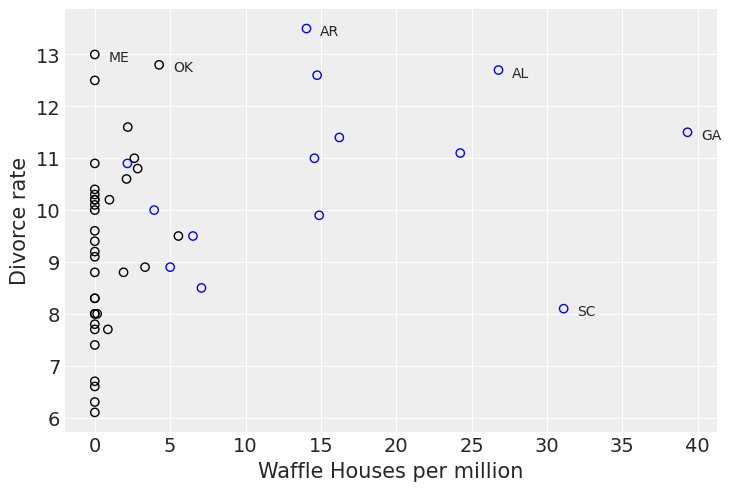

In [17]:
# Fig 5.1, missing mean
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[(data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))

Text(0.5, 0, 'Median age marriage')

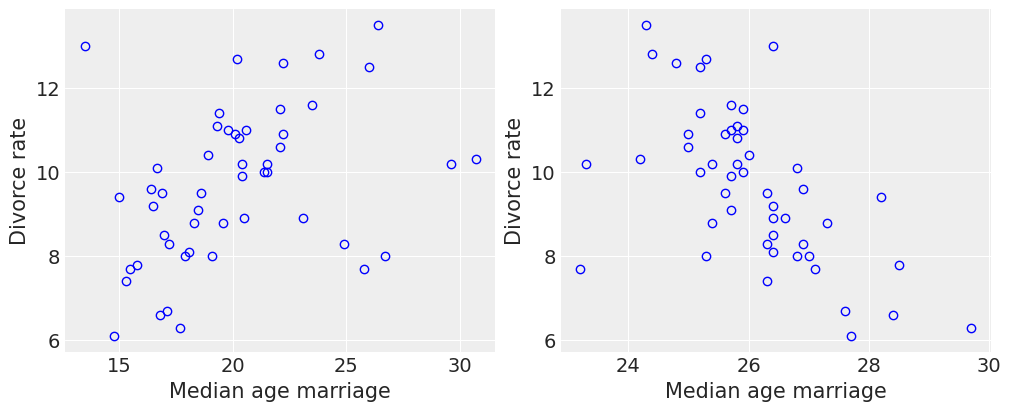

In [18]:
# Fig 5.2, missing mean and CI
fid, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Median age marriage")

ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

In [19]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

In [20]:
data["MedianAgeMarriage"].std()

1.2436303013880823

In [21]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Sampling: [a, bA, divorce_rate_std, sigma]
C:\Users\satyk\anaconda3\lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampl

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


    with pm.Model() as m_5_1:: これはPyMC3のモデルを定義するためのコンテキストマネージャ（withステートメント）です。m_5_1という名前のモデルを作成し、その中で変数や確率分布を定義します。

    a = pm.Normal("a", 0, 0.2): aという変数を定義しています。この変数は正規分布（Normal distribution）に従うと仮定され、平均が0、標準偏差が0.2と指定されています。

    bA = pm.Normal("bA", 0, 0.5): bAという変数も正規分布に従うと仮定され、平均が0、標準偏差が0.5と指定されています。

    sigma = pm.Exponential("sigma", 1): sigmaという変数は指数分布（Exponential distribution）に従うと仮定され、尺度（scale）パラメータが1と指定されています。

    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values): muという変数は、計算によって決定されるもので、aとbAの値を使用して計算されます。具体的には、線形モデル mu = a + bA * MedianAgeMarriage_std が定義され、Deterministicとして指定されています。

    divorce_rate_std = pm.Normal("divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values): divorce_rate_stdという変数は、観測データとして扱われ、正規分布に従うと仮定され、muから予測される分布として定義されています。observed引数を使用して実際のデータを指定しています。

    prior_samples = pm.sample_prior_predictive(): モデルの事前分布からサンプルを生成するためのコードです。事前分布からのランダムサンプリングを行います。

    m_5_1_trace = pm.sample(): マルコフ連鎖モンテカルロ（MCMC）サンプリングを使用して、モデルの事後分布を推定します。MCMCはベイジアン統計モデルのパラメータの事後分布をサンプリングするための手法です。m_5_1_traceにはMCMCサンプリングの結果が格納されます。

    このコードは、ベイジアン統計モデリングを行うためのPyMC3を使用した例であり、モデルの定義、事前分布からのサンプリング、およびMCMCサンプリングに関連する操作を含んでいます。ベイジアン統計モデリングは、不確実性を考慮に入れたデータ解析や予測を行うために使用されます。

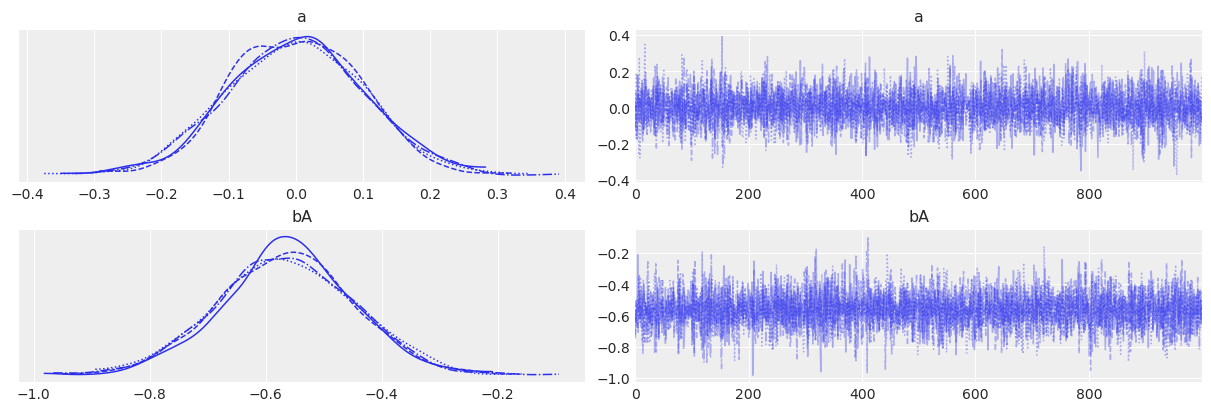

In [22]:
az.plot_trace(m_5_1_trace, var_names=["a", "bA"]);

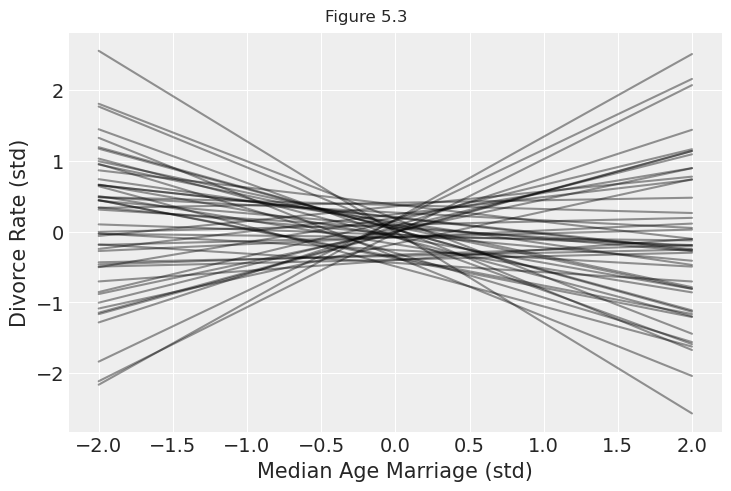

In [23]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

prior_samp_a = np.array(az.extract_dataset(prior_samples["prior"])["a"][:50])
prior_samp_bA = np.array(az.extract_dataset(prior_samples["prior"])["bA"][:50])

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

In [24]:
m_5_1_trace.posterior["bA"].shape

(4, 1000)

In [25]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# m_5_1_trace = m_5_1_trace.sel(draw=slice(None, None, 10))
m_5_1_data = az.extract_dataset(m_5_1_trace.posterior)

mu_pred = np.zeros((len(age_std_seq), len(m_5_1_data.sample)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_data["a"] + m_5_1_data["bA"] * age_std